# <center>Machine Learning Group Project - Movie Lens (Group 11)</center>
<center>Nova SBE, Spring 2021</center>
<center>Professor Qiwei Han</center>
<center>Teaching Assistant José Lucas</center>
.
<center>Authors:</center>
<center>Ângelo Figueiral, 44645</center>
<center>Diogo Cardoso, 45124</center>
<center>Pedro Rolim, 29067</center>
<center>Ricardo Araújo, 32025</center>

---
# Table of Contents

1. [Data Curation](#Data-Curation)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
3. [Business Problem](#Business-Problem)
4. [First Approach - Without Machine Learning](#First-Approach---Without-Machine-Learning)
5. [Second Approach - Neural Network](#Second-Approach---Neural-Network)
6. [Comparing Approaches](#Comparing-Approaches)
7. [Conclusion](#Conclusion)
8. [Sources](#Sources)

In [2]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Concatenate, Dense, Dropout, Input, Reshape, Dot, Add, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
%matplotlib inline

---
# Data Curation

The dataset given to us was MovieLens. We got basic data from Movies, from the ratings of these movies and respective users, the genres of the films and tags.

In [3]:
movies_df = pd.read_csv('../../dataset/MovieLens_files/movies.csv')
ratings_df = pd.read_csv('../../dataset/MovieLens_files/ratings.csv')

In [4]:
# Curating the movies dataset (into films_df)

films_df = movies_df['title'].str.extract('(.*)\((\d{4})\)', expand=False)

films_df["movieId"] = movies_df['movieId']
films_df["genres"] = movies_df['genres']
films_df.columns = ['title', 'year', 'movieId', 'genres']
films_df = films_df[['movieId', 'title', 'year', 'genres']]
films_df.head()

movieId                         title  year  \
0        1                    Toy Story   1995   
1        2                      Jumanji   1995   
2        3             Grumpier Old Men   1995   
3        4            Waiting to Exhale   1995   
4        5  Father of the Bride Part II   1995   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [5]:
# Curating the ratings dataset (into ratings)

ratings = ratings_df.merge(movies_df[['movieId','title']], how="left", left_on="movieId", right_on="movieId")

---
# Exploratory Data Analysis

The group first tried to get acquainted to the data and tried to see any patterns or important information.

In [103]:
films_df.describe()

movieId
count   27278.000000
mean    59855.480570
std     44429.314697
min         1.000000
25%      6931.250000
50%     68068.000000
75%    100293.250000
max    131262.000000

### Checking the evolution of number of movies and genres per year, across all the dataset

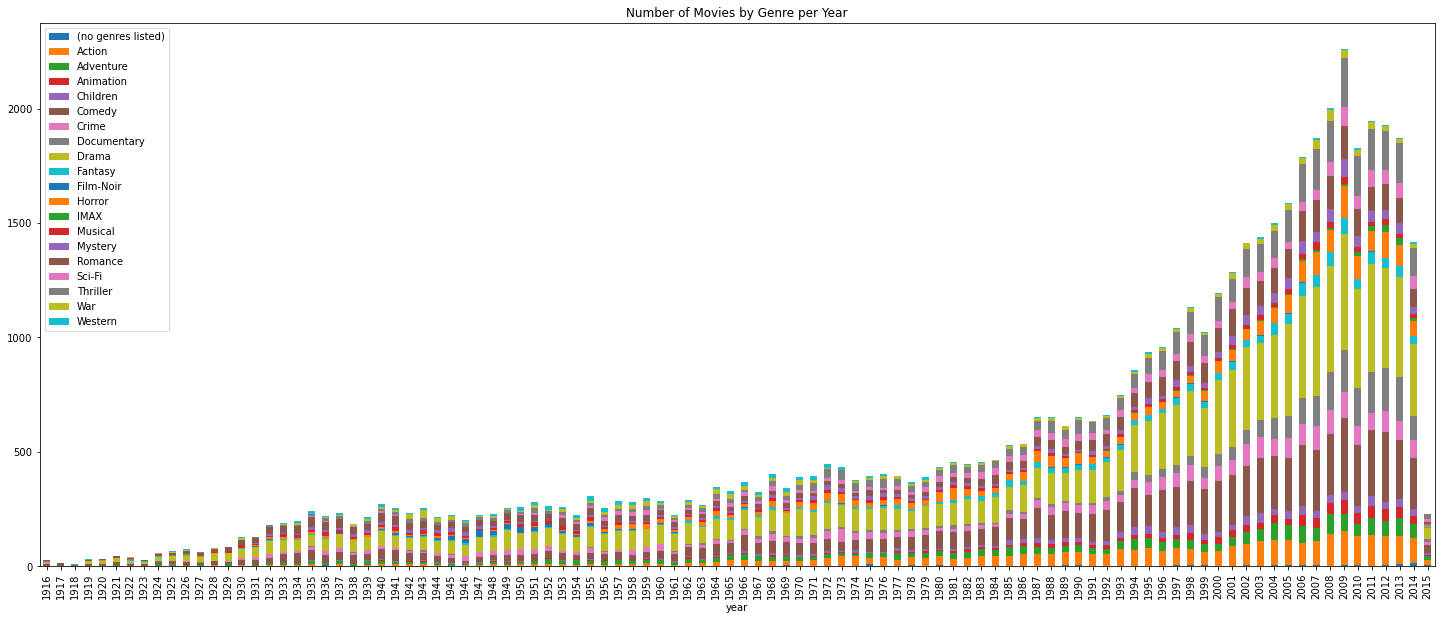

In [7]:
# Creating dummy variables for the genres
dummies = films_df['genres'].str.get_dummies(sep='|')
films_genres_df = pd.concat([films_df, dummies], axis=1)

# Plotting
films_genres_df.groupby('year').sum().iloc[-100:,1:].plot.bar(stacked=True,figsize=(25, 10), title='Number of Movies by Genre per Year')

In [18]:
ratings_df.head(5)

userId  movieId  rating   timestamp
0       1        2     3.5  1112486027
1       1       29     3.5  1112484676
2       1       32     3.5  1112484819
3       1       47     3.5  1112484727
4       1       50     3.5  1112484580

#### Before starting to think about which problem to solve or a model to implement, it is important that we have some information on a key variable in our dataset: the ratings users have given to movies.

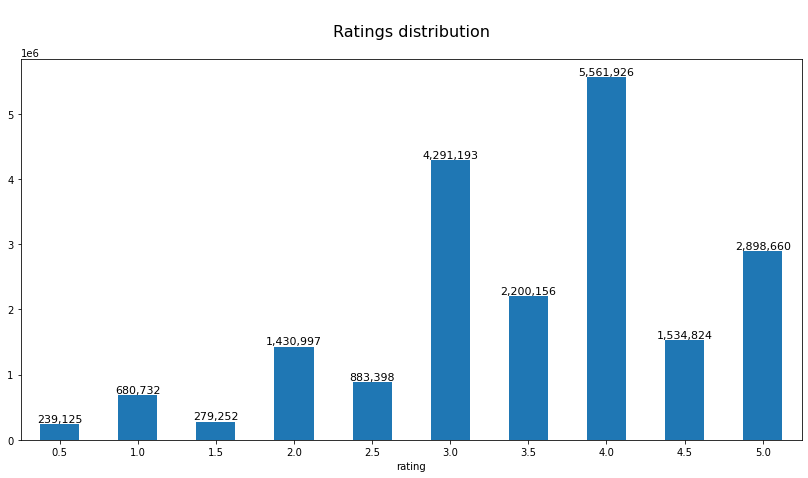

In [66]:
ratings_df.groupby('rating').agg(['count'])[(   'userId', 'count')].plot.bar(figsize = (14,7), rot = 0)
   
plt.title('\nRatings distribution\n', {"fontsize": 16})
for i in range(0,10):
    plt.text(i, (ratings_df.groupby('rating').agg(['count'])[(   'userId', 'count')][np.sort(ratings_df['rating'].unique())[i]]), 
             f"{int(ratings_df.groupby('rating').agg(['count'])[(   'userId', 'count')][np.sort(ratings_df['rating'].unique())[i]]):,}", 
             horizontalalignment='center',
             fontsize = 11,
             verticalalignment='bottom')
plt.yticks([])
plt.show()

- As we can see in the bar chart above, it is unusual for users to give ratings lower than 2.
- The most given rating was 4, while the second and third most given were 3 and 5, respectively.

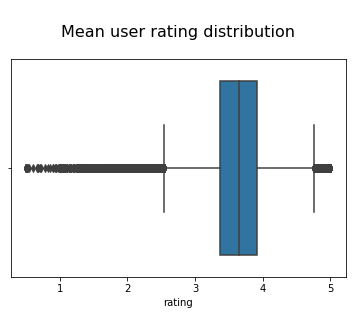

In [72]:
ax = sns.boxplot(x=(ratings_df.groupby('userId').mean()['rating']))
plt.title('\nMean user rating distribution\n', {"fontsize": 16})
plt.show()

By plotting the average movie rating of each user using a boxplot, we see that most of the data points are concentrated between approximately 3.25 and 4, with the averages below 2.5 and 4.8 being considered outliers. With this information, we can conclude that the majority of users is pondered in the ratings they give to movies, once they tend not to give ratings neither too high nor too low.

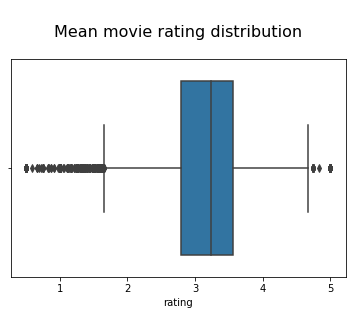

In [71]:
ax = sns.boxplot(x=ratings_df.groupby('movieId').mean()['rating'])
plt.title('\nMean movie rating distribution\n', {"fontsize": 16})
plt.show()

Finally it is also important to see what did users, on average, think of each movie. Again, we see that the majority of movies have an average rating between 2.8 and 3.6, being uncommon to find movies with higer or lower ratings than that.

---
# Business Problem

Through this notebook, we try to provide a possible solution to a big problem that streaming services have at the moment: currently, Netlfix has over 13,612 titles in its library, Disney+ has more than 7,500 television episodes and 500 film titles, and HBO MAX has more 2000 titles. It would be a waste of a client's time to have to scroll through 13000 random titles to get to a film the user wants to watch.

Indeed, these platforms already use very complex recommendation systems, which result in the maximization of the users' time watching and satisfaction with the service, ultimately leading to much higher profits. Nowadays, a streaming service without an avanced recommendation systems is considered obsolete. Reportedly, 80% of Netflix's stream time is achieved through their very complex ensemble of models (https://towardsdatascience.com/deep-dive-into-netflixs-recommender-system-341806ae3b48).

While we will not be using and testing several different models, we aim at implementing a model that receives a user ID and returns a list of movies that are recommended to him, based on his past ratings.

### Do we even need Machine Learning for this problem?

This is an important question. If we can solve this problem without Machine Learning, it would be beneficial for the company because it means less resources needed. Below, we implement a simple recommendation system without Machine Learning, in order to find out whether a better solution is needed.

---
# First Approach - Without Machine Learning

In [9]:
new_movies_df = pd.merge(ratings_df, movies_df[['movieId', 'title']],on="movieId")
new_movies_df.head()

userId  movieId  rating   timestamp           title
0       1        2     3.5  1112486027  Jumanji (1995)
1       5        2     3.0   851527569  Jumanji (1995)
2      13        2     3.0   849082742  Jumanji (1995)
3      29        2     3.0   835562174  Jumanji (1995)
4      34        2     3.0   846509384  Jumanji (1995)

In [10]:
# Seeing what are the best rated films in the dataset
new_movies_df.groupby("title").mean()['rating'].sort_values(ascending=False).head(10)

title
Prom Queen: The Marc Hall Story (2004)                        5.0
The Garden of Sinners - Chapter 5: Paradox Paradigm (2008)    5.0
Death of a Nation - The Timor Conspiracy (1994)               5.0
Poison (1951)                                                 5.0
Sun Kissed (2012)                                             5.0
Giorgino (1994)                                               5.0
Schmatta: Rags to Riches to Rags (2009)                       5.0
De la servitude moderne (2009)                                5.0
The Encounter (2010)                                          5.0
Best of Ernie and Bert, The (1988)                            5.0
Name: rating, dtype: float64

In [11]:
# Creating a new dataframe with the movie title, avg_rating and the number of times the movie was rated.
new_ratings_df1 = new_movies_df.groupby(new_movies_df['title']).mean().reset_index()[['title', 'rating']]
new_ratings_df2 = new_movies_df.groupby(new_movies_df['title']).count().reset_index()[['title', 'rating']]

new_ratings_df = new_ratings_df1.merge(new_ratings_df2, on="title")
new_ratings_df.columns = ['title', 'avg_rating', 'count_rating']
new_ratings_df.sort_values(by='avg_rating', ascending=False)

title  avg_rating  \
18750             Prom Queen: The Marc Hall Story (2004)         5.0   
23270  The Garden of Sinners - Chapter 5: Paradox Par...         5.0   
6223     Death of a Nation - The Timor Conspiracy (1994)         5.0   
18369                                      Poison (1951)         5.0   
22392                                  Sun Kissed (2012)         5.0   
...                                                  ...         ...   
23520               The Robot vs. the Aztec Mummy (1958)         0.5   
15295                                Mega Piranha (2010)         0.5   
23504                           The Radio Pirates (2007)         0.5   
8400                             First Texan, The (1956)         0.5   
996     Allan Quatermain and the Temple of Skulls (2008)         0.5   

       count_rating  
18750             1  
23270             1  
6223              1  
18369             1  
22392             1  
...             ...  
23520             1  
15295             1  
23504             1  
8400              1  
996               1  

[26729 rows x 3 columns]

### Seeing the best rated movies in the dataset, most of them are movies that are not known and have been rated only one time.

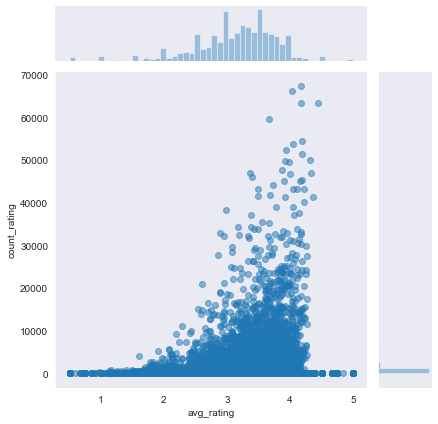

In [12]:
# Seeing the relationship between average rating and the number of times the film is rated.
sns.jointplot(x='avg_rating',y='count_rating',data=new_ratings_df,alpha=0.5)

# Insights from plot

- We can see in the plot that most films have less than 10000 ratings and there are a very small number of films that are highly popular (rated a lot of times) and highly rated (more than 3.5 stars).

**We have to find a way to take out the movies that are seen only a few number of times for the model to work.**

In [13]:
new_ratings_df['count_rating'].describe()

count    26729.000000
mean       748.260803
std       3086.673456
min          1.000000
25%          3.000000
50%         18.000000
75%        205.000000
max      67310.000000
Name: count_rating, dtype: float64

#### The group assumed 800 was a reasonable number of reviews for a film to be accepted in our recommendation system. This was a crucial step because it was important for our recommendation system to be unbiased and to work to the best it could.

In [14]:
new_ratings_df = new_ratings_df[new_ratings_df['count_rating']>800]

# Filtering in our original dataset by the films that have more than 800 ratings
new_movies_df = new_movies_df.groupby("title").filter(lambda x: len(x) >= 800)

In [15]:
moviematrix = new_movies_df.pivot_table(index="userId",columns="title",values='rating')
moviematrix.tail()

title   'burbs, The (1989)  (500) Days of Summer (2009)  \
userId                                                    
138489                 NaN                          NaN   
138490                 NaN                          NaN   
138491                 NaN                          NaN   
138492                 NaN                          NaN   
138493                 NaN                          NaN   

title   *batteries not included (1987)  ...And Justice for All (1979)  \
userId                                                                  
138489                             NaN                            NaN   
138490                             NaN                            NaN   
138491                             NaN                            NaN   
138492                             NaN                            NaN   
138493                             NaN                            NaN   

title   10 Things I Hate About You (1999)  10,000 BC (2008)  \
userId                                                        
138489                                NaN               NaN   
138490                                NaN               NaN   
138491                                NaN               NaN   
138492                                NaN               NaN   
138493                                NaN               NaN   

title   101 Dalmatians (1996)  \
userId                          
138489                    NaN   
138490                    NaN   
138491                    NaN   
138492                    NaN   
138493                    3.0   

title   101 Dalmatians (One Hundred and One Dalmatians) (1961)  \
userId                                                           
138489                                                NaN        
138490                                                NaN        
138491                                                2.5        
138492                                                NaN        
138493                                                3.5        

title   102 Dalmatians (2000)  12 Angry Men (1957)  ...  \
userId                                              ...   
138489                    NaN                  4.5  ...   
138490                    NaN                  NaN  ...   
138491                    NaN                  NaN  ...   
138492                    NaN                  NaN  ...   
138493                    NaN                  4.0  ...   

title   Zero Dark Thirty (2012)  Zero Effect (1998)  Zodiac (2007)  \
userId                                                               
138489                      NaN                 NaN            NaN   
138490                      NaN                 NaN            NaN   
138491                      NaN                 NaN            NaN   
138492                      NaN                 NaN            NaN   
138493                      NaN                 NaN            NaN   

title   Zombieland (2009)  Zoolander (2001)  Zulu (1964)  [REC] (2007)  \
userId                                                                   
138489                NaN               NaN          NaN           NaN   
138490                NaN               NaN          NaN           NaN   
138491                NaN               NaN          NaN           NaN   
138492                NaN               NaN          NaN           NaN   
138493                NaN               NaN          NaN           NaN   

title   eXistenZ (1999)  xXx (2002)  ¡Three Amigos! (1986)  
userId                                                      
138489              NaN         NaN                    NaN  
138490              NaN         NaN                    NaN  
138491              NaN         NaN                    NaN  
138492              NaN         NaN                    NaN  
138493              NaN         NaN                    NaN  

[5 rows x 3556 columns]

In [26]:
moviematrix.tail(5)

title   'burbs, The (1989)  (500) Days of Summer (2009)  \
userId                                                    
138489                 NaN                          NaN   
138490                 NaN                          NaN   
138491                 NaN                          NaN   
138492                 NaN                          NaN   
138493                 NaN                          NaN   

title   *batteries not included (1987)  ...And Justice for All (1979)  \
userId                                                                  
138489                             NaN                            NaN   
138490                             NaN                            NaN   
138491                             NaN                            NaN   
138492                             NaN                            NaN   
138493                             NaN                            NaN   

title   10 Things I Hate About You (1999)  10,000 BC (2008)  \
userId                                                        
138489                                NaN               NaN   
138490                                NaN               NaN   
138491                                NaN               NaN   
138492                                NaN               NaN   
138493                                NaN               NaN   

title   101 Dalmatians (1996)  \
userId                          
138489                    NaN   
138490                    NaN   
138491                    NaN   
138492                    NaN   
138493                    3.0   

title   101 Dalmatians (One Hundred and One Dalmatians) (1961)  \
userId                                                           
138489                                                NaN        
138490                                                NaN        
138491                                                2.5        
138492                                                NaN        
138493                                                3.5        

title   102 Dalmatians (2000)  12 Angry Men (1957)  ...  \
userId                                              ...   
138489                    NaN                  4.5  ...   
138490                    NaN                  NaN  ...   
138491                    NaN                  NaN  ...   
138492                    NaN                  NaN  ...   
138493                    NaN                  4.0  ...   

title   Zero Dark Thirty (2012)  Zero Effect (1998)  Zodiac (2007)  \
userId                                                               
138489                      NaN                 NaN            NaN   
138490                      NaN                 NaN            NaN   
138491                      NaN                 NaN            NaN   
138492                      NaN                 NaN            NaN   
138493                      NaN                 NaN            NaN   

title   Zombieland (2009)  Zoolander (2001)  Zulu (1964)  [REC] (2007)  \
userId                                                                   
138489                NaN               NaN          NaN           NaN   
138490                NaN               NaN          NaN           NaN   
138491                NaN               NaN          NaN           NaN   
138492                NaN               NaN          NaN           NaN   
138493                NaN               NaN          NaN           NaN   

title   eXistenZ (1999)  xXx (2002)  ¡Three Amigos! (1986)  
userId                                                      
138489              NaN         NaN                    NaN  
138490              NaN         NaN                    NaN  
138491              NaN         NaN                    NaN  
138492              NaN         NaN                    NaN  
138493              NaN         NaN                    NaN  

[5 rows x 3556 columns]

In [69]:
# Function to recommend a user some movies based on their preferences

def predict_movies(user_id):
    
    # Get the user's favorite movie
    fav_movie = moviematrix.loc[user_id].idxmax(axis=1)
    
    # Get ratings of the user's favorite movie
    movie_user_ratings=moviematrix[fav_movie]
    
    # Creating column which shows the correlation of the ratings between the movie chosen and all other movies that other users have also watched
    similar_to_matrix=moviematrix.corrwith(movie_user_ratings)
    
    # Creating a dataframe for better visualization
    corr_matrix=pd.DataFrame(similar_to_matrix,columns=['correlation'])
    
    # Dropping the movies that have not been watched by the people that have watched the movie
    corr_matrix.dropna(inplace=True)
    
    # Creating a new dataframe because our previous one was a groupby and it's impossible to perform the next transformations
    new_df = pd.DataFrame({
    'title': corr_matrix.index,
    'correlation': corr_matrix.correlation # correlation with the user's favorite movie
    })
    del new_df['title']
    new_df = new_df.reset_index()
    corr_starwars=new_df.merge(new_ratings_df[['count_rating', 'title']], on="title")
    
    # Show the 10 films that are recommended if someone wants to watch a similar movie to their favorite one
    predictions = corr_starwars[corr_starwars['count_rating']>100].sort_values('correlation',ascending=False)[1:]
    return predictions.head(10)

In [55]:
# Trying it out for user 27382
predict_movies(27382)

title  correlation  count_rating
125                           Aliens (1986)     0.616702         27206
3175                 Terminator, The (1984)     0.430560         33429
1692                            Jaws (1975)     0.397363         22168
3196                      Thing, The (1982)     0.390843          8557
1651  Invasion of the Body Snatchers (1978)     0.379895          1506
415                     Blade Runner (1982)     0.377936         30526
1066                   Exorcist, The (1973)     0.374727         13359
2539                        Predator (1987)     0.364438         14537
1173                        Fly, The (1986)     0.363402         10174
2524                     Poltergeist (1982)     0.353421          9026

In [46]:
# Trying it out for a random user
predict_movies(random.randint(1, len(moviematrix)))

title  correlation  count_rating
2754                           Runaway Bride (1999)     0.552473          8159
768                               Crossroads (2002)     0.541456           921
2919  Sisterhood of the Traveling Pants, The (2005)     0.504347           816
3062                                 Stepmom (1998)     0.502597          2026
1550            How to Lose a Guy in 10 Days (2003)     0.493105          3546
3435                    Wedding Planner, The (2001)     0.488280          3883
2544                            Pretty Woman (1990)     0.479950         33900
624                     Cheaper by the Dozen (2003)     0.476866          1446
1081                       Failure to Launch (2006)     0.475934           988
1115                     Father of the Bride (1991)     0.473035          2628

## Approach Evaluation

As correlations between movies are generally low,  predictions are not very accurate. In general, this approach seems too simplistic to address the problem.

More importantly, this ends up being an item-based model rather than user-based, which is the end goal.

It is also worth mentioning that there is no way we can get test metrics on this model, since the dataset was not split across training and validation sets.

#### Considering these points, we clearly needed a stronger and deeper solution. A Neural Network is the literature-recommended approach to solve this issue, and that's where we are going next.

---
# Second Approach - Neural Network

In [8]:
# The user/movie fields are currently sequential integers representing some unique ID for that entity. 
# We need them to be sequential starting at zero to use for modeling (right now, the userId starts at 1 and needs to starts at 0). We use scikit-learn's LabelEnconcer to transform the fields.
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()
item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)

# We’ll also create variables with the total number of unique users and movies in the data, 
#as well as the min and max ratings present in the data, for reasons that will become apparent shortly.
n_movies = ratings['movie'].nunique()
ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

n_users, n_movies, min_rating, max_rating

(138493, 26744, 0.5, 5.0)

In [9]:
# Splitting the data

X = ratings[['user', 'movie']].values

# What we want to know
y = ratings['rating'].values
X_train, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape, X_test.shape, y_train_full.shape, y_test.shape)
print(X)

(18000236, 2) (2000027, 2) (18000236,) (2000027,)
[[     0      1]
 [     0     28]
 [     0     31]
 ...
 [138492  13875]
 [138492  13993]
 [138492  14277]]


In [10]:
print(y)

[3.5 3.5 3.5 ... 3.  5.  2.5]


In [11]:
# Another constant we’ll need for the model is the number of factors per user/movie. 
# This number can be whatever we want, however for the collaborative filtering model it does need to be the same size for both users and movies.
n_factors = 50

# Finally, we need to turn users and movies into separate arrays in the training and test data.
# This is because in Keras they’ll each be defined as distinct inputs, and the way Keras works is each input needs to be fed in as its own array.
full_X_train_array = [X_train[:, 0], X_train[:, 1]]
full_X_test_array = [X_test[:, 0], X_test[:, 1]]

X_train = [full_X_train_array[0][9000118:],full_X_train_array[1][9000118:]]
y_train = y_train_full[9000118:] 
X_valid = [full_X_train_array[0][:9000118],full_X_train_array[1][:9000118]]
y_valid = y_train_full[:9000118]

In [16]:
# As we can see, X_train_array is a list with two arrays: one with users, the other with movies
print(f'Users array:\n{full_X_train_array[0].shape}\n\nMovies Array:\n{full_X_train_array[1].shape}')

Users array:
(18000236,)

Movies Array:
(18000236,)


In [196]:
def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    """
    Returns the model that can predict user ratings for different films
    
    Parameters
    ----------
    n_users : int 
        number of unique users in the database
        
    n_movies : int 
        number of unique movies in the database
        
    n_factors : int
        number of factors per user/movie we want to have. It is the same size for movies and users
        
    min_rating : int 
        minimum rating a user can give a film
        
    max_rating : int 
        maximum rating a user can give a film

    Returns
    ----------
    model : tensorflow.python.keras.engine.functional.Functional
        The tensorflow/keras model is returned
    
    """
    
    # Initiate a Keras tensor
    # Allows us to use users (in this case) and movies (a few lines below) as input
    # The input is shape is (1,) because (in our case) 1 is the length of each userId
    # The input of the Keras Input function is a tuple without specifying the batch size
    user = Input(shape=(1,))
    
    # Creating an Embedding layer that takes as an input dimensions the number of users and transforms it into the output dimensions.
    # In this case, the output dimensions is the number of factors because we want to create a vector with 50 factors that characterizes the user in this case (or movie below).
    # We use l2 regularizer for regularization
    # We use the he_normal initializer because that is what we used in class/on the notebooks professor Qiwei provided.
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    
    # Shape of u right now is (None, 1, 50). We want it to be only a vector with 50 factors witht he shape (None, 50) to concatenate with the m, so we have to user a reshape layer.
    u = Reshape((n_factors,))(u)
    
    # We use the same procedure for the movies
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    # Concatenating them together to create our real independent variable to train the NN
    x = Concatenate()([u, m])
    
    # We use Dropout because, like we saw in classes, it achieves State-of-The-Art results. In this case our dropout rate is 5%.
    x = Dropout(0.05)(x)
    
    # We create a regular dense layer to the NN and apply dropout again as the regularization technique
    x = Dense(10, kernel_initializer='he_normal', activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # We tried to do another layer with relu as the activation function but the results were poorer than with sigmoid.
    # So run this output through a sigmoid activation function on the layer...
    x = Dense(1, kernel_initializer='he_normal',activation='sigmoid')(x)
    
    # and then scale the result with the ratings so that it gives us the result in the 0.5 - 5 stars range.
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    
    # putting everything into the keras model with an Adam optimizer and then compiling everything while calculation the MSE as the loss
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error", dtype=None))
    
    return model

In [18]:
model = RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        6924650     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        1337200     input_2[0][0]                    
______________________________________________________________________________________________

In [19]:
# Using a batch_size of 1000 because it needs less memory (it would take a lot of time to run them without a batch)
# and to train the NN faster (the weights are only updated after each propagation)

# We are training the model with 30 epochs and recording the error in order to find the optimal number

history = model.fit(x=X_train, y=y_train, batch_size=1000, epochs=30,
                    verbose=1, validation_data=(X_valid, y_valid))


# Warning: this cell takes about 11 hours to run

Epoch 1/30
9001/9001 [==============================] - 1382s 153ms/step - loss: 0.8966 - mean_absolute_error: 0.7363 - val_loss: 0.7682 - val_mean_absolute_error: 0.6669
Epoch 2/30
9001/9001 [==============================] - 1334s 148ms/step - loss: 0.8065 - mean_absolute_error: 0.6869 - val_loss: 0.7593 - val_mean_absolute_error: 0.6622
Epoch 3/30
9001/9001 [==============================] - 1362s 151ms/step - loss: 0.7966 - mean_absolute_error: 0.6822 - val_loss: 0.7522 - val_mean_absolute_error: 0.6601
Epoch 4/30
9001/9001 [==============================] - 1365s 152ms/step - loss: 0.7880 - mean_absolute_error: 0.6791 - val_loss: 0.7481 - val_mean_absolute_error: 0.6582
Epoch 5/30
9001/9001 [==============================] - 1365s 152ms/step - loss: 0.7853 - mean_absolute_error: 0.6779 - val_loss: 0.7484 - val_mean_absolute_error: 0.6583
Epoch 6/30
9001/9001 [==============================] - 1365s 152ms/step - loss: 0.7847 - mean_absolute_error: 0.6774 - val_loss: 0.7485 - val_me

In [20]:
# Evaluate model
model.evaluate(full_X_test_array, y_test)

62501/62501 [==============================] - 1886s 30ms/step - loss: 0.7425 - mean_absolute_error: 0.6549s - loss: 0.7425 - mean_abs


[0.7424651980400085, 0.6549148559570312]

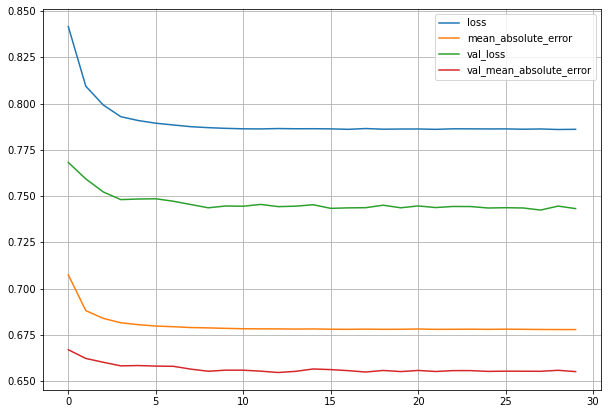

In [21]:
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)

plt.show()

### Should we train the model for more epochs?

##### As we can see on the graph, the validation and training error&loss are already almost parallel, they don't decrease much after increasing the epochs (sometimes they even increase a little). For that reason, the group thinks the **loss decrease / time spending training** ratio is too low to continue training for more epochs. Like we learned in classes, the model should be as light, as explainable and as easy to use as possible instead of having the best accuracy/least error.

### But why is the validation error inferior to the training error? Is there an error in our Neural Network?

##### NO! We use L2 regularization and Dropout regularization to help our model generalize better to data the NN has never seen. In other words, we use it to obtain higher validation/testing accuracy. **Regularization methods often sacrifice training accuracy** to improve validation/testing accuracy — **sometimes that leads to errors being inferior in the validation/test sets.**

### What does this error tell us?

##### The model, on average, has an error of ~0.65 in the ratings of movies. In our case, it means that if an user gives a 3.5 stars rating to a movie, on average, the model will probably predict that the user will give the film a rating between ~3 to ~4 stars.

### So, what number of epochs should be used in the practical sense?

#### 3 epochs should be used, since that is where the trade-off between time and performance is optimal.

In [220]:
model.save("recommendation_system.h5")

## Hyperparameters Fine-Tuning

The group tried different variations of the optimizer , learning rate, batch size, and epochs. These are the optimal hyperparameters we found:

- **Optimizer and Learning Rate**: After trying different optimizers with different learning rates, we found that the best optimizer was the Adam optimizer with a learning rate of 0.001 for this problem in specific - this code is not available in this notebook as it is quite extensive.

- **Batch size**: the smaller the batch size, the smaller the error. However, we also prioritezed the time it took to run: the smaller the batch size, the higher the time needed for the model to train. We reached the compromise of running a batch size of 1000.

- **Epochs**: 3 epochs should be used, since that is where the trade-off between time and performance is optimal.

In [210]:
def predict_ratings(): 
    """Predicts the ratings and returns the real ratings of the films the users have already seen (the users and movies on the test set)

    Parameters
    ----------
    user : int
        The user_id of the user we want to checkout the ratings

    Returns
    ----------
    df : pandas.core.frame.DataFrame
        Returns a dataframe filtered by the user column
    """
    
    # Getting the y_predict from the test array
    y_proba = model.predict(full_X_test_array)
    y_proba = y_proba.round(2)
    
    # Putting everything in a dataframe: the user_id, the movie_id and the predicted and real rating the user has given to that film
    d = {'user': full_X_test_array[0], 'movie_id': full_X_test_array[1], 'predicted_rating': y_proba[:,0], 'real_rating': y_test}
    df = pd.DataFrame(data=d)
    
    return df

In [212]:
predict_ratings()

user  movie_id  predicted_rating  real_rating
0         35021      3945              3.23          3.0
1        112746      3732              2.43          2.0
2          1229        30              3.43          5.0
3        138449       362              2.49          3.0
4         33877      3276              4.27          4.0
...         ...       ...               ...          ...
2000022   68855      2676              4.14          4.0
2000023   93358      1694              1.57          0.5
2000024   91190      2286              3.75          5.0
2000025   29055       988              2.45          3.5
2000026   22288     11161              4.08          3.5

[2000027 rows x 4 columns]

#### The results of the model are satisfatory and they actually are inline with the Mean Absolute Error and MSE given, as expected.

In [213]:
def predict_ratings_user(user):
    """Predicts the ratings of the films the user has seen. The user_id has to be in the test set

    Parameters
    ----------
    user : int
        The user_id of the user we want to checkout the ratings. The user_id has to be in the test set

    Returns
    ----------
    df : pandas.core.frame.DataFrame
        Returns a dataframe filtered by the user column
    """
    
    # Getting the y_predict from the test array
    y_proba = model.predict(full_X_test_array)
    y_proba = y_proba.round(2)
    
    # Putting everything in a dataframe: the user_id, the movie_id and the predicted and real rating the user has given to that film
    d = {'user': full_X_test_array[0], 'movie_id': full_X_test_array[1], 'predicted_rating': y_proba[:,0], 'real_rating': y_test}
    df = pd.DataFrame(data=d)
    
    return df[df['user']==user]

In [215]:
predict_ratings_user(93358)

user  movie_id  predicted_rating  real_rating
32850    93358      1719              2.82          3.5
43746    93358      1242              3.84          3.0
68810    93358      4898              3.18          3.5
76211    93358      1588              3.10          3.5
87361    93358      9515              2.68          3.0
...        ...       ...               ...          ...
1941791  93358      5860              3.51          4.0
1946271  93358      9814              3.13          3.0
1955432  93358      1669              3.67          2.0
1981017  93358       834              2.34          3.0
2000023  93358      1694              1.57          0.5

[107 rows x 4 columns]

#### These are useful to compare the performance of the model in a real life situation, but it's not the finished product we wanted! What we want is to predict films a certain user has not watched yet!

#### We do that in the next function called **best_movies_by_user**: after inputting one user, **the function returns the respective predicted ratings for films that that user hasn't watched.**

In [252]:
def best_movies_by_user(user):
    """Predicts the best movie for a given user

    Parameters
    ----------
    user : int
        The user_id of the user we want to recommend a film.

    Returns
    ----------
    new_df : pandas.core.frame.DataFrame
        Returns a dataframe that only has films the user has not seen sorted by the predicted rating.
    """
    
    # Creating a new test set of all the films in the entire dataset and creating an array of the same size populated with the user_id
    X_movies = ratings['movie'].unique()
    X_user = np.full((1, len(X_movies)), user)

    # List with the two arrays
    user_predict = [X_user[0], X_movies]

    # Predicted film ratings
    y_proba = model.predict(user_predict)
    y_proba = y_proba.round(2)

    # Creating the data frame
    d = {'user': user_predict[0], 'movie_id': user_predict[1], 'predicted_rating': y_proba[:,0]}
    df = pd.DataFrame(data=d)

    # Adding to the dataframe the title of the movie
    movies_titles = ratings[['movie', 'title']]
    movies_titles=movies_titles.drop_duplicates()
    
    new_df = df.merge(movies_titles[['movie', 'title']], how = 'left',
                   left_on = 'movie_id', right_on = 'movie').drop(columns= ['movie'])

    # Creating a dataframe with movies that the user has already seen
    user_movies_rated = ratings[ratings['user']==user]
    user_movies_rated = user_movies_rated[['user', 'movie']]

    # Outter merging the user_movies_rated with the new_df to only recommend films that the user has not seen
    new_df = new_df.merge(user_movies_rated[['user', 'movie']], how='outer', left_on = 'movie_id', right_on = 'movie', indicator=True)
    new_df = new_df[new_df['_merge'] == 'left_only'].drop(columns= ['user_y', 'movie', '_merge'])
    new_df = new_df.rename(columns={'user_x': 'user'})
    
    # Returning the dataframe with the values sorted by the predicted rating
    return new_df.sort_values(by='predicted_rating', ascending=False).head(15)

In [254]:
best_movies_by_user(118204)

user  movie_id  predicted_rating  \
5265  118204     15188              4.15   
5267  118204     17015              4.14   
5269  118204     18939              4.14   
2807  118204     16916              4.11   
5475  118204      5591              4.10   
5337  118204      6873              4.09   
3812  118204       660              4.09   
9797  118204      5401              4.08   
4082  118204     18550              4.07   
5268  118204     18642              4.07   
2810  118204     17125              4.06   
2205  118204      2845              4.06   
2818  118204     17837              4.05   
8248  118204     18845              4.04   
9321  118204     22571              4.04   

                                                  title  
5265                                            Cosmos   
5267                             Louis C.K.: Hilarious   
5269                                      Black Mirror   
2807                                             Senna   
5475           Grave of the Fireflies (Hotaru no haka)   
5337  Passion of Joan of Arc, The (Passion de Jeanne...  
3812         Song of the Little Road (Pather Panchali)   
9797                               Red Beard (Akahige)   
4082            Louis C.K.: Live at the Beacon Theater   
5268                                    Civil War, The   
2810                                         Incendies   
2205              Time of the Gypsies (Dom za vesanje)   
2818           Separation, A (Jodaeiye Nader az Simin)   
8248                                     North & South   
9321                                                NaN

In [258]:
best_movies_by_user(46469)

user  movie_id  predicted_rating  \
2019  46469      1935              3.66   
1285  46469     10901              3.65   
1343  46469      1178              3.65   
456   46469       905              3.63   
7410  46469      6559              3.58   
245   46469       887              3.57   
5141  46469      8935              3.56   
3496  46469      3047              3.55   
2037  46469       909              3.54   
5265  46469     15188              3.53   
5338  46469      7421              3.53   
5269  46469     18939              3.53   
5260  46469      3220              3.53   
3978  46469      4912              3.52   
2416  46469      1186              3.52   

                                              title  
2019          Seven Samurai (Shichinin no samurai)   
1285  Lives of Others, The (Das leben der Anderen)   
1343                                  12 Angry Men   
456         Sunset Blvd. (a.k.a. Sunset Boulevard)   
7410                                         Ikiru   
245                                    Rear Window   
5141                      Decalogue, The (Dekalog)   
3496           Grand Illusion (La grande illusion)   
2037                                 All About Eve   
5265                                        Cosmos   
5338   Wages of Fear, The (Salaire de la peur, Le)   
5269                                  Black Mirror   
5260                                   City Lights   
3978                   Witness for the Prosecution   
2416                                Third Man, The

In [256]:
best_movies_by_user(125793)

user  movie_id  predicted_rating  \
3259  125793      1155              4.41   
5141  125793      8935              4.39   
5269  125793     18939              4.37   
3203  125793       661              4.37   
2037  125793       909              4.36   
184   125793       891              4.36   
6039  125793      7657              4.35   
2807  125793     16916              4.35   
8273  125793      7497              4.35   
4832  125793      8643              4.34   
4996  125793      1982              4.34   
3419  125793      2645              4.34   
7115  125793      9159              4.34   
4945  125793      8595              4.34   
2650  125793     18484              4.33   

                                         title  
3259                           Paths of Glory   
5141                 Decalogue, The (Dekalog)   
5269                             Black Mirror   
3203          World of Apu, The (Apur Sansar)   
2037                            All About Eve   
184                        North by Northwest   
6039            Sunrise: A Song of Two Humans   
2807                                    Senna   
8273       Virgin Spring, The (Jungfrukällan)   
4832           Andrei Rublev (Andrey Rublyov)   
4996                          Out of the Past   
3419  400 Blows, The (Les quatre cents coups)   
7115               From the Earth to the Moon   
4945                       Harakiri (Seppuku)   
2650                             Intouchables

---
# Comparing Approaches

### First Aproach - Without Machine Learning | Positives, Limitations & Business Applications

- The "Without Machine Learning" solution is based on the correlations between ratings. This makes it more explainable and easier for any person in a company, for example, to adapt the solution to different contexts and make some slight changes.

- After comparing some of its recommendation with the IMDB recommendation system, the model seemed to actually have a nice performance: most of its recommendations based on a certain films were also recommendations from the IMDB for that film.

- The solution has severe limitations: it ends up being an item-based (in this case, film-based) recommendation system: even though the group implemented a simple workaround that involves choosing the best rated film of a certain user and making the recommendation based only on that film, that solution still lacks a lot in terms of being a personalized recommendation system.

- Another important thing to mention is that it's difficult to evaluate it: unlike a real model, here we don't have a training and testing set, making it impossible for us to check if the user would actually like the movies recommended. This is a crucial part and a real setback when trying to understand if it should be implemented in a company or not. However, if the company wanted to do a test-run of this solution, it could use some of the evaluation metrics we learned in class, like the Hit-rate or Cumulative Hit Rate.

**BUSINESS APPLICATION**

The group still thinks this solution is a great film-based recommendation system and should be tested, maybe as a feature called **"If you liked this movie, maybe you should try...".**

### Second Approach - Neural Network | Positives, Limitations & Business Applications

- The Neural Nework actually gives us personalized recommendations, which was our end-goal all along.

- Although we win in personalized recommendations, we also lose some explainability: it's more difficult to explain what actually happens and it's harder to explain to a person that doesn't know anything about Machine Learning or Neural Networks what is actually happening. **However, we think this problem was mitigated because the group provided various comments and explanations throughout this notebook that try to go step-by-step on what is actually happening and what are the variables and hyperparameters that can be changed.** This way, we think that the model can be explained to the higher-ups in the company and allow for business decisions to be taken. 

- Another thing that is important to mention is that the model takes a lot of time to be trained: in a normal computer, each epoch needs 10 to 20 minutes to run on the training and validation set. This contrasts with the previous "No Machine Learning" solution, where the longest step in the process is creating the moviematrix variable.

- Unlike the "No Machine Learning" solution, here we **can evaluate the Neural Network performance on the training, validation and test sets** through the Mean Squared Error and Mean Absolute Error.

- One limitation of the model is that when we choose a user that has seen a reduced number of films and series (<20) the model returns standard movie recommendations to these users. To mitigate this, we would need to collect data on the ratings of these new movies watched by those users and run it again afterwards.

- There is about ~0.6 Mean Absolute Error in the Test Set, which was achieved with a simple Neural Network. We tried different combinations of hyperparameters and achieved what we thought was the best combination, but maybe someone with more experience in the NN field can go even further. It is important to notice, hovewer, that more complexity most of the times comes with less explainability, so we were actually happy with the present results.

- The model can be further refined and finetuned when its put into production and the results of metrics like the Cumulative Hit-rate are known.

**BUSINESS APPLICATION**

We would advise the company to implement this recommendation system as a feature called **"Recommended For You"**, as it narrows the user search times for a filme and leads to a better overall customer experience.

---
# Conclusion

The Neural Network model gives a more personalized experience and was actually evaluated, leading the group to think of it as the strongest solution out of the two.

However, we think both solutions can and should be used inside the same product: Netflix or Disney+, for example, can implement these recommendation systems in diffent sections like we said: one called **"If you liked this movie, maybe you should try...".** and another called **"Recommended For You"**.

They are two different solutions that improve customer experience and add value to streaming services or even to film databases, like IMDB or Letterboxd, because they filter movies that the user will probably like while filtering out the ones that the user will most probably not like.

These models can be even further finetuned with Hit-rate metrics, just like we learned in class.

---
# Sources

1. Gomez-Uribe, C. A., &amp; Hunt, N. (2016). The Netflix recommender system. ACM Transactions on Management Information Systems, 6(4), 1-19. doi:10.1145/2843948

2. Ghosh, S. (2018, March 17). Recommender system on THE movielens dataset using an autoencoder and Tensorflow in Python. Retrieved May 5, 2021, from https://medium.com/@connectwithghosh/recommender-system-on-the-movielens-using-an-autoencoder-using-tensorflow-in-python-f13d3e8d600d

3. Wittenauer, J. (2019, April 29). Deep learning With KERAS: Recommender systems. Retrieved May 11, 2021, from https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929

4. Sedhain, S., Menon, A. K., Sanner, S., &amp; Xie, L. (2015). AutoRec. Proceedings of the 24th International Conference on World Wide Web. doi:10.1145/2740908.2742726

---
Thank you! If you have any questions, please do not hesitate to contact any member of the group :)